## Importing libraries and combining the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
mmScaler = MinMaxScaler()
sScaler = StandardScaler()

In [2]:
df1 = pd.read_csv('hdb_nearest_bus.csv')
# print the dataset 
df1

,Unnamed: 0,Unnamed: 1,BusStopCode,RoadName,Description,Latitude,Longitude,UpDown,LeftRight,Distance,Postal
0,26103.0,457,43581,Bt Batok West Ave 5,Blk 347,1.362519,103.751384,-15,0,95.032670,650383
1,NaN,458,43589,Bt Batok West Ave 5,Opp Blk 347,1.362273,103.751532,-15,0,76.282252,650383
2,38564.0,457,43581,Bt Batok West Ave 5,Blk 347,1.362519,103.751384,-15,0,100.970052,650384
3,NaN,458,43589,Bt Batok West Ave 5,Opp Blk 347,1.362273,103.751532,-15,0,103.767223,650384
4,38593.0,470,43649,Bt Batok West Ave 7,HomeTeamNS,1.365458,103.750602,-15,1,185.836015,650388
...,...,...,...,...,...,...,...,...,...,...,...
780,NaN,128,65269,Punggol Ctrl,Blk 162B,1.396710,103.914672,18,7,164.042097,820643
781,50968.0,393,67499,Sengkang West Ave,Fernvale Pr Sch,1.390680,103.874679,10,6,193.928437,792407
782,78835.0,88,72021,Bedok Reservoir Rd,Blk 646,1.330965,103.906322,16,-6,107.509833,410647
783,NaN,89,72029,Bedok Reservoir Rd,Opp Blk 646,1.330864,103.906552,16,-6,133.086871,410647


In [3]:
df2 = pd.read_csv('hdb_to_mrt_all.csv')
# print the dataset 
df2

C:\Users\samik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,month,town,flat_type,blk_no,street,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,no,lng_mrt,lat_mrt,mahattan_distance,mrt_cbd_dist,mrt_cbd_time,hdb_cbd_distance,hdb_cbd_time,hdb_to_mrtdist,sgd_persqm
0,26103,2017-03,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,07 TO 09,92.0,Model A,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4836.96
1,26104,2017-04,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,19 TO 21,90.0,Model A,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,5143.20
2,26105,2017-05,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,01 TO 03,90.0,Model A,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4388.89
3,26106,2017-09,BUKIT BATOK,5 ROOM,383,BT BATOK WEST AVE 5,10 TO 12,115.0,Improved,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4782.61
4,26107,2017-12,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,10 TO 12,90.0,Model A,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4588.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89618,16451,2018-05,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,07 TO 09,101.0,Model A,1998,...,107,103.758034,1.378619,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3287.13
89619,16455,2018-08,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,13 TO 15,101.0,Model A,1998,...,107,103.758034,1.378619,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3712.87
89620,16459,2018-11,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,01 TO 03,100.0,Model A,1998,...,107,103.758034,1.378619,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3250.00
89621,16463,2020-03,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,04 TO 06,100.0,Model A,1998,...,107,103.758034,1.378619,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3350.00


In [4]:
# combined = df2.merge(df1, on=['Postal'])

In [5]:
combined = df2
combined.columns

Index(['Unnamed: 0', 'month', 'town', 'flat_type', 'blk_no', 'street',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'Unnamed: 0.1', 'max_floor_lvl',
       'year_completed', 'residential', 'commercial', 'market_hawker',
       'miscellaneous', 'multistorey_carpark', 'precinct_pavilion',
       'bldg_contract_town', 'total_dwelling_units', '1room_sold',
       '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold',
       'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental', 'lat_hdb',
       'lng_hdb', 'building', 'addr', 'Postal', 'SUBZONE_NO', 'SUBZONE_N',
       'SUBZONE_C', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N', 'REGION_C',
       'MRT_NAME', 'MRT_ID', 'line', 'no', 'lng_mrt', 'lat_mrt',
       'mahattan_distance', 'mrt_cbd_dist', 'mrt_cbd_time', 'hdb_cbd_distance',
       'hdb_cbd_time', 'hdb_to_mrtdist', 'sgd_persqm'],
      dtyp

In [6]:
# combined = combined.drop(['no','Unnamed: 0_x','Unnamed: 0.1','lat_hdb','lng_hdb','lng_mrt', 'lat_mrt','Unnamed: 0_y', 'Unnamed: 1',
#        'BusStopCode','Description', 'Latitude', 'Longitude',
#        'UpDown', 'LeftRight', 'RoadName', 'line', 'MRT_ID'], axis=1)

In [7]:
combined = combined.drop(['no','Unnamed: 0','Unnamed: 0.1','lat_hdb','lng_hdb','lng_mrt', 'lat_mrt', 'MRT_ID'], axis=1)

## Adjusting for inflation 
to be done

## Comparison between types of HDBs
We need to recognise that some HDBs have multistory carparks in the lower levels while others do not. 
Some HDBs have hawkers in built, others have commercial shops like value dollar shops. 

So what are the HDB facilities? 
1. Commercial!
2. Multistory carpark!
4. Precint_pavillion!

what are the combination available in the given dataset?

1. Pure residential 
2. Residential and Commercial Only
3. Residential, Commercial with carpark (6 rows only)
4. Residential and pavilion

In [8]:
residential = combined.loc[(combined['residential']=="Y") & (combined['commercial']=="N") & (combined['multistorey_carpark']=="N") & (combined['precinct_pavilion']=="N")]
res_and_comm = combined.loc[(combined['residential']=="Y") & (combined['commercial']=="Y") & (combined['multistorey_carpark']=="N") & (combined['precinct_pavilion']=="N")]
res_comm_car = combined.loc[(combined['residential']=="Y") & (combined['commercial']=="Y") & (combined['multistorey_carpark']=="Y") & (combined['precinct_pavilion']=="N")]
res_pav = combined.loc[(combined['residential']=="Y") & (combined['commercial']=="N") & (combined['multistorey_carpark']=="N") & (combined['precinct_pavilion']=="Y")]

In [9]:
def printgraph(x:str,y:str):
    X=residential[[x]]
    Y=residential[[y]]
    
    titlestr = x + ' against ' + y + ' for purely residential HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
    print("\n\n\n")
    X=res_and_comm[[x]]
    Y=res_and_comm[[y]]
    
    titlestr = x + '  against ' + y + ' for residential, commercial HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
    print("\n\n\n")
    X=res_comm_car[[x]]
    Y=res_comm_car[[y]]
    
    titlestr = x + '  against ' + y + ' for residential, commercial, carpark HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
    print("\n\n\n")
    X=res_pav[[x]]
    Y=res_pav[[y]]
    
    titlestr = x + '  against ' + y + ' for residential, pavilion HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
def printmenu():
    llist = ['floor_area_sqm', 'resale_price', 'max_floor_lvl','total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'mahattan_distance', 'mrt_cbd_dist',
       'mrt_cbd_time', 'hdb_cbd_distance', 'hdb_cbd_time', 'hdb_to_mrtdist',
       'sgd_persqm', 'Distance']
    
    print("Below are the variables: ")
    count = 0
    for item in llist:
        print("item ", count, ": ", item)
        count +=1
        
    x_var = int(input("Choose x variable (type in the item number only!): \n"))
    y_var = int(input("Choose y variable (type in the item number only!): \n"))
    
    
    return llist[x_var], llist[y_var]

# Continuous Variables 

## User guide to using the below cell:

1. press shift + enter to run the cell. 
2. Enter the item number you wish to compare. Only numbers allowed


Below are the variables: 
item  0 :  floor_area_sqm
item  1 :  resale_price
item  2 :  max_floor_lvl
item  3 :  total_dwelling_units
item  4 :  1room_sold
item  5 :  2room_sold
item  6 :  3room_sold
item  7 :  4room_sold
item  8 :  5room_sold
item  9 :  exec_sold
item  10 :  multigen_sold
item  11 :  studio_apartment_sold
item  12 :  1room_rental
item  13 :  2room_rental
item  14 :  3room_rental
item  15 :  other_room_rental
item  16 :  mahattan_distance
item  17 :  mrt_cbd_dist
item  18 :  mrt_cbd_time
item  19 :  hdb_cbd_distance
item  20 :  hdb_cbd_time
item  21 :  hdb_to_mrtdist
item  22 :  sgd_persqm
item  23 :  Distance
Choose x variable (type in the item number only!): 
19
Choose y variable (type in the item number only!): 
22


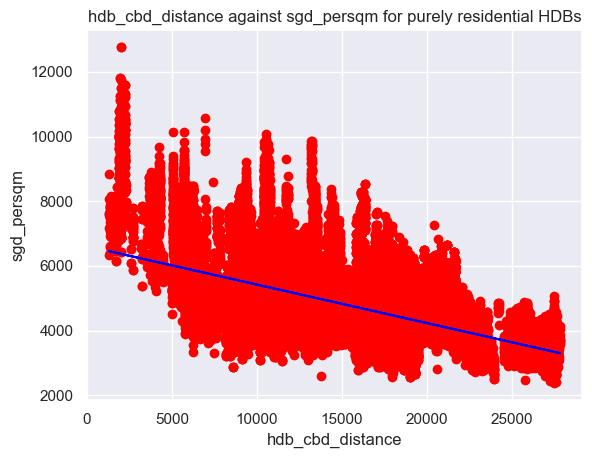

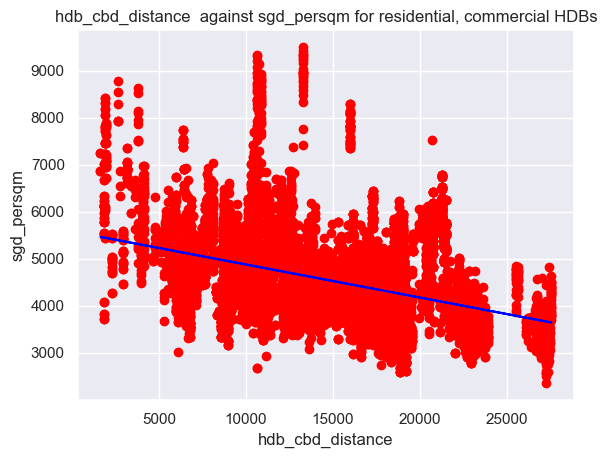

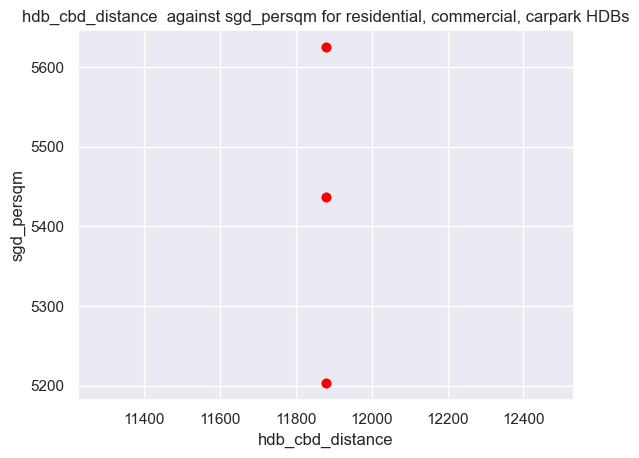

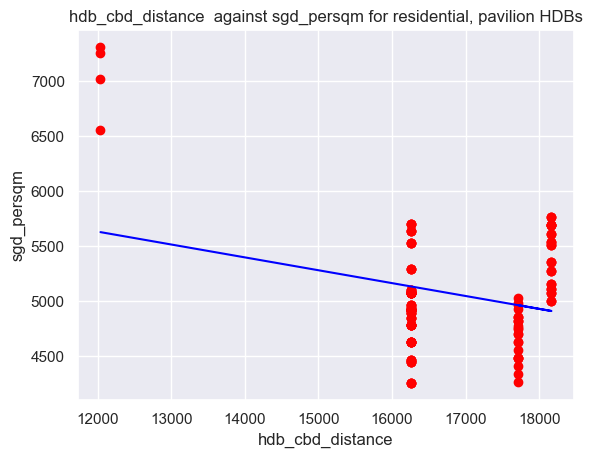

In [10]:
x_var, y_var = printmenu()
printgraph(str(x_var), str(y_var))

# Categorical Variables

The below will only allow y variable to be sgd_persqm or resale price!

## User guide to using the below cell:

1. press shift + enter to run the cell. 
2. Enter the item number you wish to compare. Only numbers allowed


In [13]:
def printgraph2(X:str,Y:str):
    
    f = plt.figure(figsize=(16,8))
    sb.boxplot(x=X, y=Y, data = residential)
    
    f = plt.figure(figsize=(16,8))
    sb.boxplot(x=X, y=Y, data = res_and_comm)
    
    f = plt.figure(figsize=(16,8))
    sb.boxplot(x=X, y=Y, data = res_comm_car)
    
    f = plt.figure(figsize=(16,8))
    sb.boxplot(x=X, y=Y, data = res_pav)
    
    
    
def printmenu2():
    llist = ['month', 'town', 'flat_type', 'blk_no', 'street', 'storey_range',
       'flat_model', 'lease_commence_date',
       'remaining_lease', 'year_completed',
       'residential', 'commercial', 'market_hawker', 'miscellaneous',
       'multistorey_carpark', 'precinct_pavilion', 'bldg_contract_town',
       'building', 'SUBZONE_NO', 'line',
       'SUBZONE_N', 'SUBZONE_C', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N',
       'REGION_C', 'MRT_NAME']
    
    print("Below are the variables: ")
    count = 0
    for item in llist:
        print("item ", count, ": ", item)
        count +=1
        
    x_var = int(input("Choose x variable (type in the item number only!): \n"))
    
    yvar = ['resale_price','sgd_persqm']
    
    count = 0
    for item in yvar:
        print("item ", count, ": ", item)
        count +=1
    
    y_var = int(input("Choose y variable (type in the item number only!): \n"))
    
    
    return llist[x_var], yvar[y_var]

Below are the variables: 
item  0 :  month
item  1 :  town
item  2 :  flat_type
item  3 :  blk_no
item  4 :  street
item  5 :  storey_range
item  6 :  flat_model
item  7 :  lease_commence_date
item  8 :  remaining_lease
item  9 :  year_completed
item  10 :  residential
item  11 :  commercial
item  12 :  market_hawker
item  13 :  miscellaneous
item  14 :  multistorey_carpark
item  15 :  precinct_pavilion
item  16 :  bldg_contract_town
item  17 :  building
item  18 :  SUBZONE_NO
item  19 :  line
item  20 :  SUBZONE_N
item  21 :  SUBZONE_C
item  22 :  PLN_AREA_N
item  23 :  PLN_AREA_C
item  24 :  REGION_N
item  25 :  REGION_C
item  26 :  MRT_NAME
Choose x variable (type in the item number only!): 
19
item  0 :  resale_price
item  1 :  sgd_persqm
Choose y variable (type in the item number only!): 
1


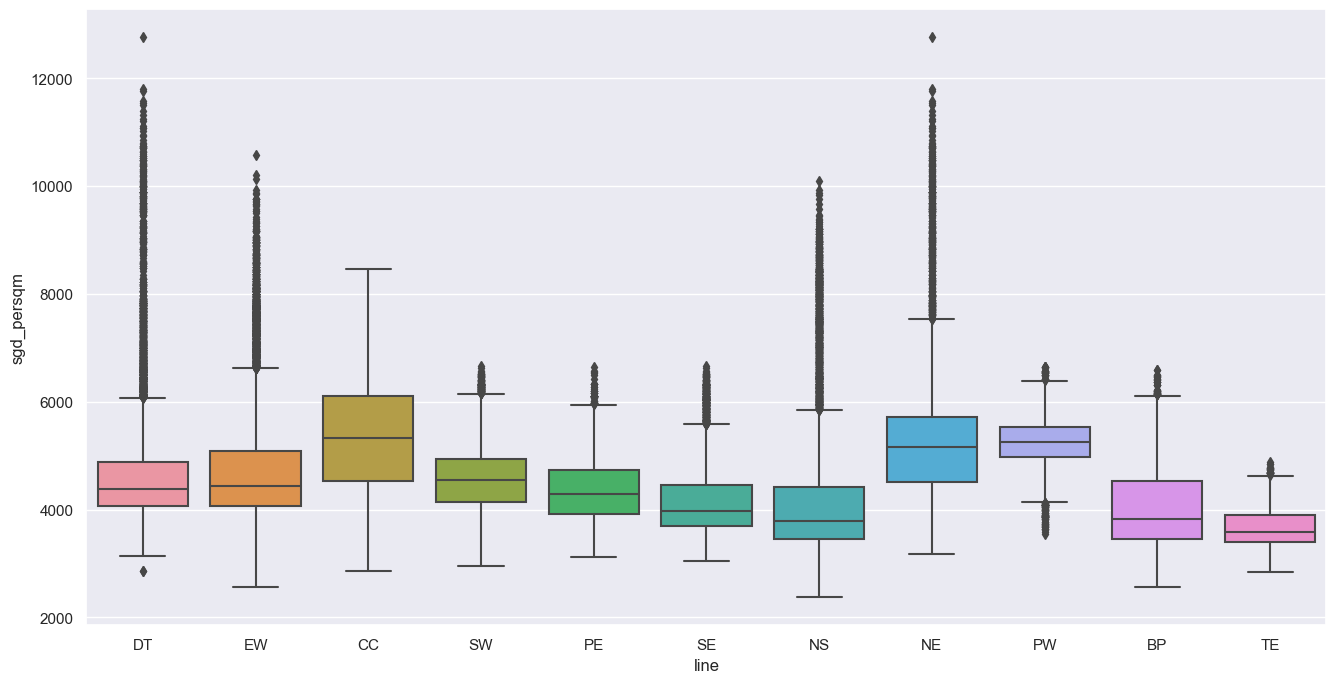

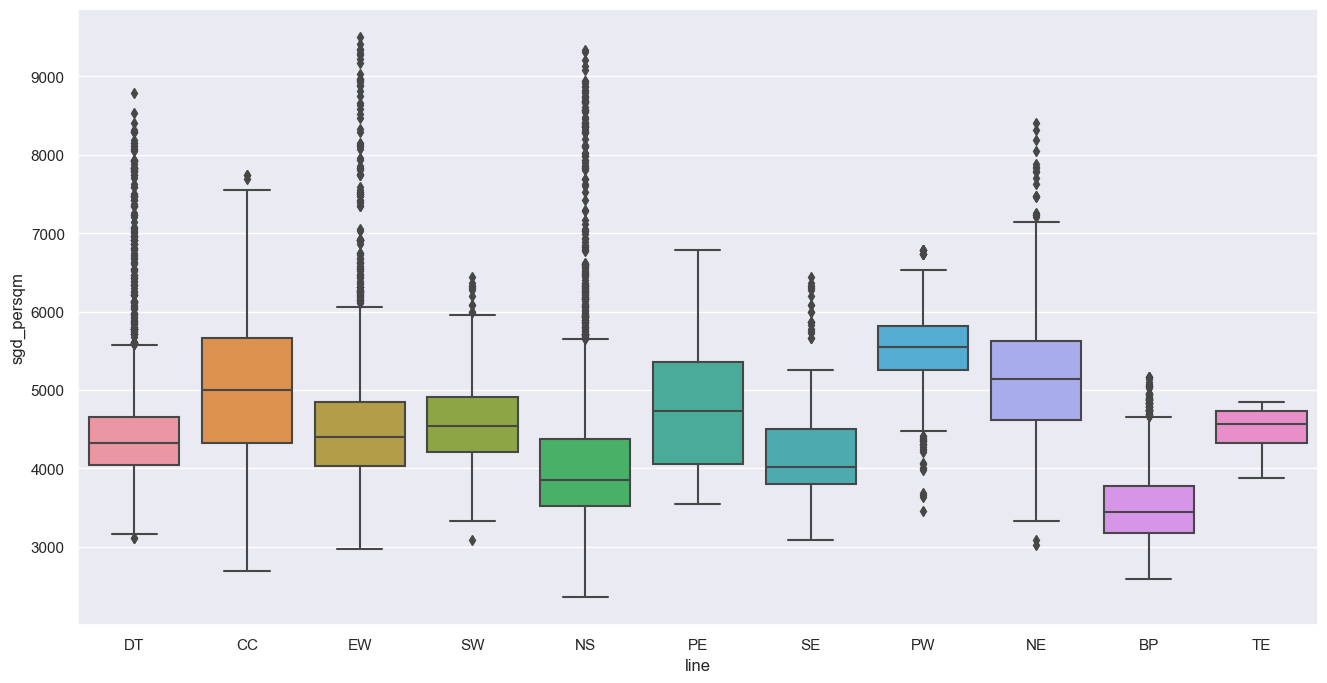

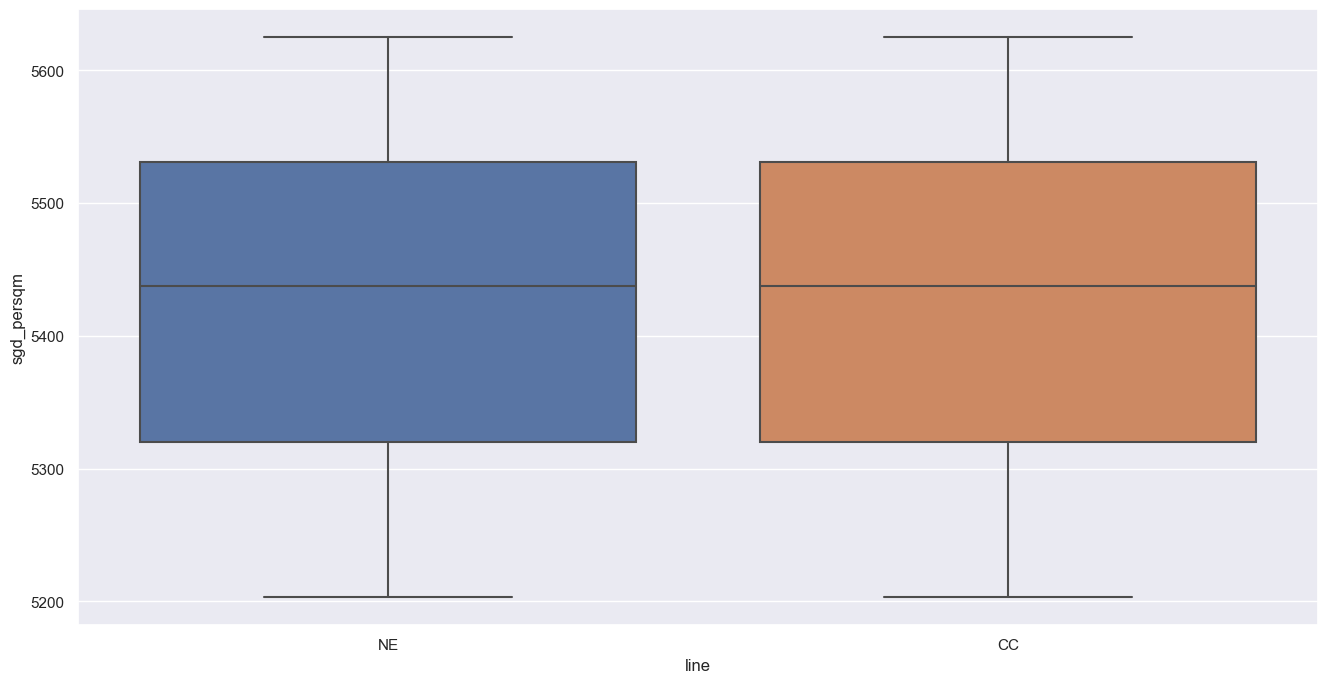

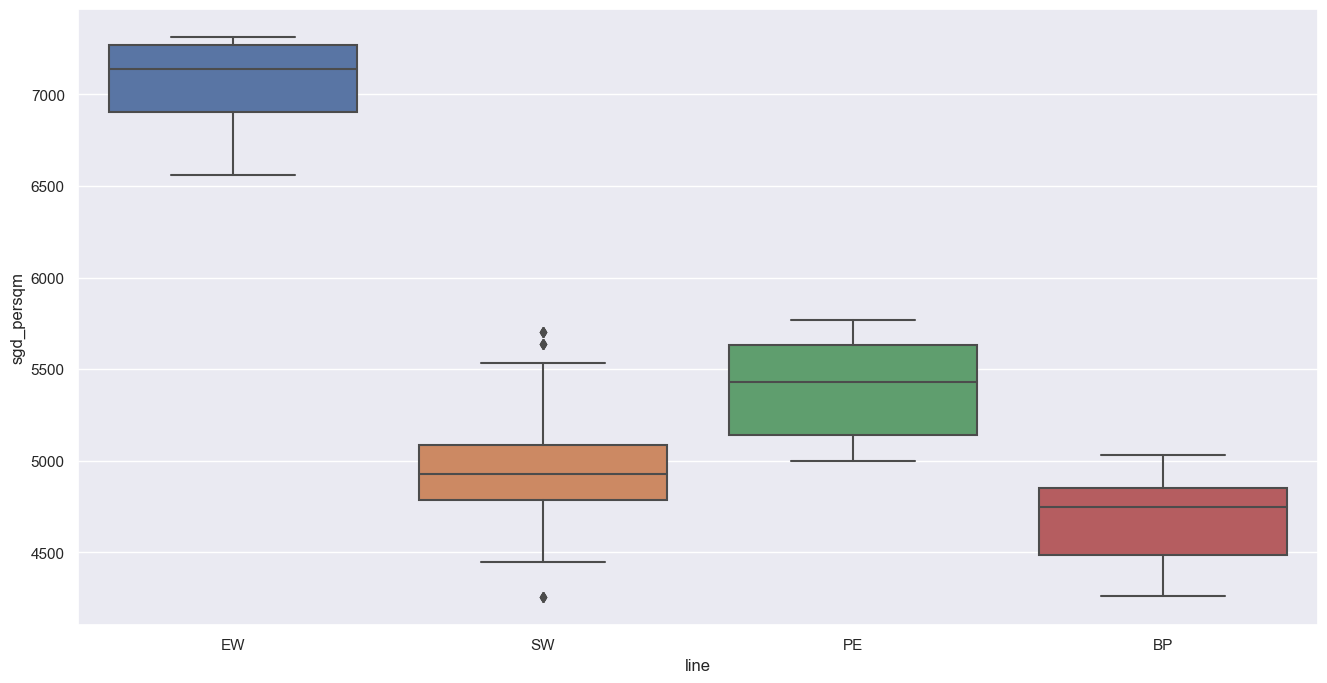

In [14]:
x_var, y_var = printmenu2()

printgraph2(x_var,y_var)